# Triangular2DMesh validation

## Step 1: basic validation

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import DSPPythonWrapper as wrp
import ipywidgets as widgets

## Global parameters/constants
plt.rcParams['figure.figsize'] = [6, 6]

In [2]:
mesh_width = 104.5  # mm
mesh_height = 104.5  # mm
spatial_resolution = 5  # mm

mesh = wrp.Triangular2DMesh(mesh_width, mesh_height,
    spatial_resolution)

mesh_coords = mesh.GetMeshCoordinates()
# How large should this vector be?
lenk_internal = np.ceil(mesh_width * 2 / spatial_resolution)
lenk_internal += 1 - np.mod(lenk_internal, 2)
expected_c = np.ceil(mesh_height / (spatial_resolution
    * np.sqrt(3) / 2))
expected_c += np.mod(expected_c, 2)
expected_k_odd = lenk_internal // 2
expected_k_even = lenk_internal // 2 + 1
expected_data_length = expected_c * expected_k_even - (expected_c // 2)
assert(expected_data_length == mesh_coords.shape[0])
assert(2 == mesh_coords.shape[1])
assert(mesh_coords.dtype == np.float32)
print("All assertions passed")

All assertions passed


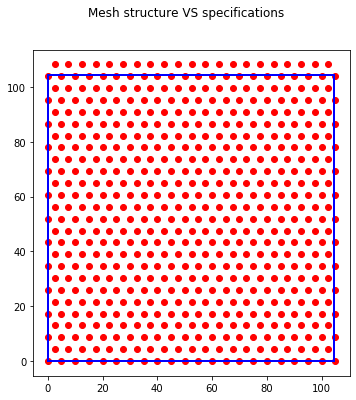

In [3]:
## Plot mesh coordinates

def plot_mesh(title):
    fig = plt.figure()
    ax = plt.axes()
    plt.scatter(mesh_coords[:,0], mesh_coords[:,1], c="r")
    ax.set_aspect("equal")
    fig.suptitle(title)
    return (fig, ax)

fig, ax = plot_mesh("Mesh structure VS specifications")
from matplotlib.patches import Rectangle
mesharea = Rectangle((0, 0), mesh_width, mesh_height, facecolor='none', linewidth=2, edgecolor="b")
_ = ax.add_patch(mesharea)

In [4]:
## Inspect mesh mask

mesh_mask = mesh.GetMask()
assert(expected_data_length == mesh_mask.shape[0])
assert(6 == mesh_mask.shape[1])
print("All assertions passed")

All assertions passed


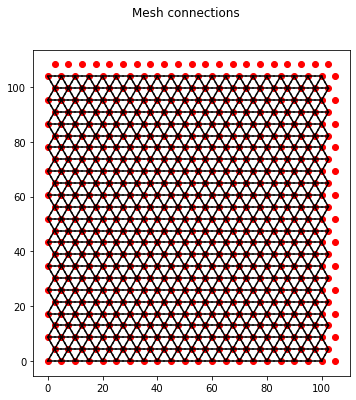

In [5]:
## Plot mesh mask structure
# Commented out, takes too long
def getLinePoints(xp, yp, direction):
    """
    xp, yp: coordinates of the mesh point
    direction: enum of the direction clockwise (NE, E, SE, SW, W, NW)
    """
    angles = np.arange(-np.pi/3, 5/3*np.pi, np.pi/3)
    yd = np.sin(angles[direction]) * spatial_resolution / 2 + yp
    xd = np.cos(angles[direction]) * spatial_resolution / 2 + xp
    return ((xd, xp), (yd, yp))

fig, ax = plot_mesh("Mesh connections")
for point_idx, point_coords in enumerate(mesh_coords):
    point_mask = mesh_mask[point_idx]
    for dir, dirmask in enumerate(point_mask):
        if point_mask[dir]:
            plt.plot(*getLinePoints(*point_coords, dir), color="k")

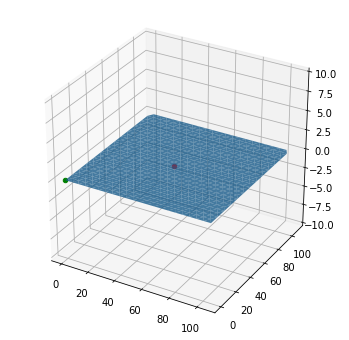

In [6]:
## Verify zeroing-out of initial junction pressure

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
_ = ax.plot_trisurf(mesh_coords[:,0], mesh_coords[:,1], mesh.GetV(),
    alpha=0.8)
sourcex, sourcey = mesh.GetSource()
pickupx, pickupy = mesh.GetPickup()
_ = ax.scatter(sourcex, sourcey, 0, color="r")
_ = ax.scatter(pickupx, pickupy, 0, color="g")
_ = ax.set_zlim([-10, 10])

unsigned int impulse_length = 21;
float impulse[impulse_length] = 
{
    0.01137871167519538, 0.026633939280853638, 0.057003245030845216, 0.11155412024665476, 
    0.19961515645360556, 0.32660533403633385, 0.488624112788967, 0.6684183720941176, 
    0.8360720857424218, 0.956226842945176, 1.0, 0.956226842945176, 
    0.8360720857424218, 0.6684183720941176, 0.488624112788967, 0.32660533403633385, 
    0.19961515645360556, 0.11155412024665476, 0.057003245030845216, 0.026633939280853638, 
    0.01137871167519538
};


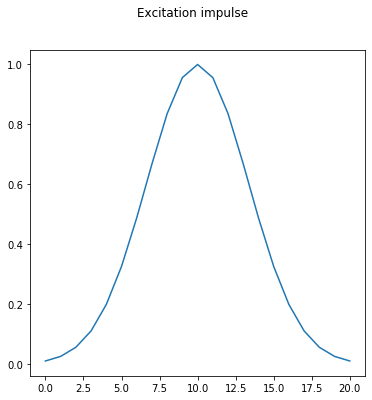

In [7]:
## Generate Gaussian impulse as stimulus
from scipy.signal import gaussian
M = 21
impulse = gaussian(M, M/2/np.pi)
#impulse *= np.sin(2 * np.pi * np.arange(M) / M)
fig = plt.figure()
fig.suptitle("Excitation impulse")
ax = fig.gca()
fig_ = ax.plot(impulse)
# Serialise C-style into textbox for export
impulse_data_str = ["\n    " + str(n) if i % 4 == 0 else str(n) for i,n in enumerate(impulse)]
impulse_str = "float impulse[impulse_length] = \n{%s\n};" % (
    ", ".join(impulse_data_str)
)
print("unsigned int impulse_length = %s;" % M)
print(impulse_str)

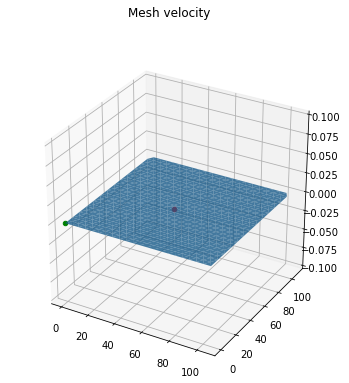

In [10]:
## Nice looking animation

import matplotlib.animation

# Uncomment if unit impulse (Kronecker delta) needs using instead
#impulse = np.array([1.])

# Plot creation
fig3d = plt.figure()
fig3d.suptitle("Mesh velocity")
ax3d = fig3d.gca(projection='3d')
sourcex, sourcey = mesh.GetSource()
pickupx, pickupy = mesh.GetPickup()
_ = ax3d.scatter(sourcex, sourcey, 0, color="r")
_ = ax3d.scatter(pickupx, pickupy, 0, color="g")
_ = ax3d.plot_trisurf(mesh_coords[:,0], mesh_coords[:,1], mesh.GetV(),
    alpha=0.8)

# Pre-allocate mesh output
tail_length = 50
total_length = len(impulse) + tail_length
mesh_output = np.zeros([total_length, *mesh.GetV().shape])
signal = np.zeros([total_length])

# Processing
mesh.Reset()
# ...Attenuation?
#mesh.SetAttenuation(0.1)
# Impulse
for smpidx, imp_sample in enumerate(impulse):
    signal[smpidx] = mesh.ProcessSample(True, imp_sample)
    mesh_output[smpidx] = mesh.GetV()
# Tail
for n in range(tail_length):
    signal[len(impulse) + n] = mesh.ProcessSample(False, 0)
    mesh_output[len(impulse) + n] = mesh.GetV()

# Animation processing
def animate(i):
    ax3d.clear()
    ax3d.set_zlim([-0.1, 0.1])
    #ax3d.set_zlim([-1, 1])
    ax3d.plot_trisurf(mesh_coords[:,0], mesh_coords[:,1], mesh_output[i],
        alpha=0.8)
    ax3d.scatter(sourcex, sourcey, 0, color="r")
    return ax3d.scatter(pickupx, pickupy, 0, color="g")

ani = matplotlib.animation.FuncAnimation(fig3d, animate, frames=total_length)

from IPython.display import HTML
HTML(ani.to_jshtml())


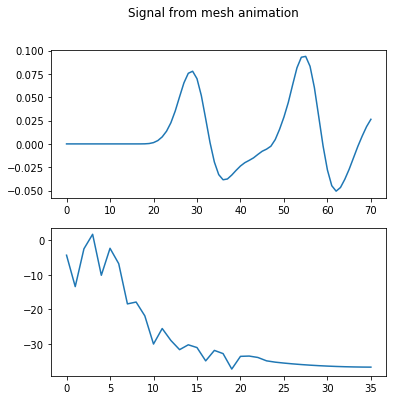

In [25]:
fig = plt.figure()
fig.suptitle("Signal from mesh animation")
ax1 = plt.subplot(211)
ax1.plot(signal)
ax2 = plt.subplot(212)
ax2.plot(
    20 * np.log10(np.abs(np.fft.rfft(signal)))
)

## Step 2: sound simulation

In [11]:
## Design the mesh in theory
time_sample_rate = 44100.  # mm
sim_mesh_width = 1200.  # mm
sim_mesh_height = 628. #sim_mesh_width * 0.75  # mm
medium_speed = 641. * 1000.  # mm/s
spatial_sample_rate = np.sqrt(2.) * medium_speed * 1./time_sample_rate
attenuation = 0.005

print("Mesh dimensions: %s x %s mm" % (sim_mesh_width, sim_mesh_height))
print("Medium speed: %s mm / s" % medium_speed)
print("Spatial sampling: %s mm" % spatial_sample_rate)
print("Points needed: %s by %s" % (np.ceil(sim_mesh_width / spatial_sample_rate),
    np.ceil(sim_mesh_height / np.sqrt(3) * 2 / spatial_sample_rate)))
print("\n")
print("""Properties p {
    %s,  // width mm
    %s,  // height mm
    %s,  // spatial sampling mm
}""" % (sim_mesh_width, sim_mesh_height, spatial_sample_rate))

Mesh dimensions: 1200.0 x 628.0 mm
Medium speed: 641000.0 mm / s
Spatial sampling: 20.5558025732688 mm
Points needed: 59.0 by 36.0


Properties p {
    1200.0,  // width mm
    628.0,  // height mm
    20.5558025732688,  // spatial sampling mm
}


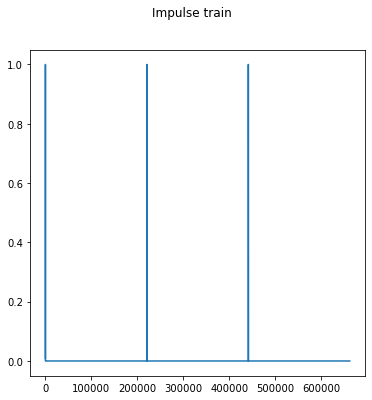

In [12]:
## Make a train of impulses
from scipy.signal import gaussian
n_impulses = 3
impulse_rate = 5 * time_sample_rate
impulse_duration = 51
total_duration = n_impulses * impulse_rate
pause_between_impulses = impulse_rate - impulse_duration

impulse = gaussian(impulse_duration, impulse_duration/2/np.pi)
impulse_train = np.concatenate([
    np.concatenate([impulse, np.zeros([int(pause_between_impulses)])]) \
    for _ in range(n_impulses)])

fig = plt.figure()
fig.suptitle("Impulse train")
_ = plt.plot(impulse_train)

In [13]:
## Create the mesh and process the data

# Little solution for a progress bar taken from
# https://www.mikulskibartosz.name/how-to-display-a-progress-bar-in-jupyter-notebook/
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)


mesh = wrp.Triangular2DMesh(sim_mesh_width, sim_mesh_height,
    spatial_sample_rate)
mesh.SetAttenuation(attenuation)
output = np.zeros(impulse_train.shape)
for n, x_n in enumerate(impulse_train):
    output[n] = mesh.ProcessSample(True, x_n)
    if (n % (total_duration // 100) == 0):
       update_progress(n / total_duration)
update_progress(1)


Progress: [####################] 100.0%


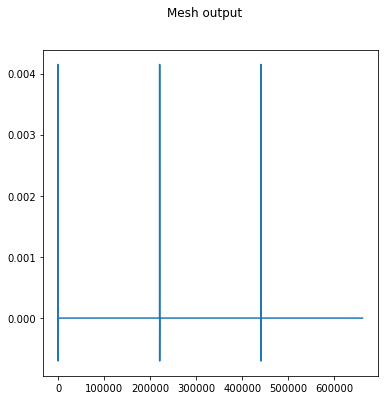

In [14]:
fig = plt.figure()
fig.suptitle("Mesh output")
_ = plt.plot(output)

output_norm = output / np.max(output)

from scipy.io import wavfile
wavfile.write("%.1f_%.1f_%.1f_mesh_output_%d.wav" % \
    (sim_mesh_width, sim_mesh_height, spatial_sample_rate,
    int(time_sample_rate)), int(time_sample_rate), output_norm)